In [1]:
# Install required package
!pip install librosa

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define file paths
csv_path = r"C:\Users\Vibhore sagar\NLP\shl\shl-intern-hiring-assessment\Dataset\train.csv"
audio_dir = r"C:\Users\Vibhore sagar\NLP\shl\shl-intern-hiring-assessment\Dataset\audios\train"

In [4]:
# Load and preprocess the dataset
df = pd.read_csv(csv_path)
df['filename'] = df['filename'].astype(str).str.strip()
df['filename'] = df['filename'].apply(lambda x: x if x.endswith('.wav') else x + '.wav')

In [5]:
# Check for any missing audio files
missing_files = df[~df['filename'].apply(lambda x: os.path.exists(os.path.join(audio_dir, x)))]
print(f"Missing files: {len(missing_files)}")

Missing files: 0


In [6]:
# Feature extraction using MFCC
def extract_features(file_path, sr=16000, n_mfcc=40):
    y, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.concatenate([np.mean(mfcc, axis=1), np.std(mfcc, axis=1)])

In [7]:
# Extract features and labels
X, y = [], []

for _, row in df.iterrows():
    file_path = os.path.join(audio_dir, row["filename"])
    try:
        features = extract_features(file_path)
        X.append(features)
        y.append(row["label"])  # Ensure this column exists as target
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

X = np.array(X)
y = np.array(y)

C:\Users\Vibhore sagar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [8]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
# Build a simple feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
])

C:\Users\Vibhore sagar\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.7405 - mae: 2.6150 - val_loss: 2.6052 - val_mae: 1.3205
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9254 - mae: 1.0443 - val_loss: 1.9286 - val_mae: 1.1655
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4626 - mae: 0.9725 - val_loss: 1.6531 - val_mae: 1.0523
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3887 - mae: 0.9980 - val_loss: 1.4911 - val_mae: 0.9884
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0504 - mae: 0.8255 - val_loss: 1.4212 - val_mae: 0.9664
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9430 - mae: 0.7994 - val_loss: 1.3294 - val_mae: 0.9358
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8835 - mae: 0.7676 - val_loss: 1.3015 - val_mae: 0.9171
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9041 - mae: 0.7540 - val_loss: 1.2785 - val_mae: 0.9198
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8469 - mae:

In [13]:
# Predict on validation set
y_val_pred = model.predict(X_val)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [14]:
# Compute evaluation metrics
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation R² Score: {r2_val:.4f}")
print(f"Validation MAE: {mae_val:.4f}")

Validation RMSE: 0.9266
Validation R² Score: 0.3656
Validation MAE: 0.7475


In [15]:
# Predict on training set
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {rmse_train:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training RMSE: 0.4455


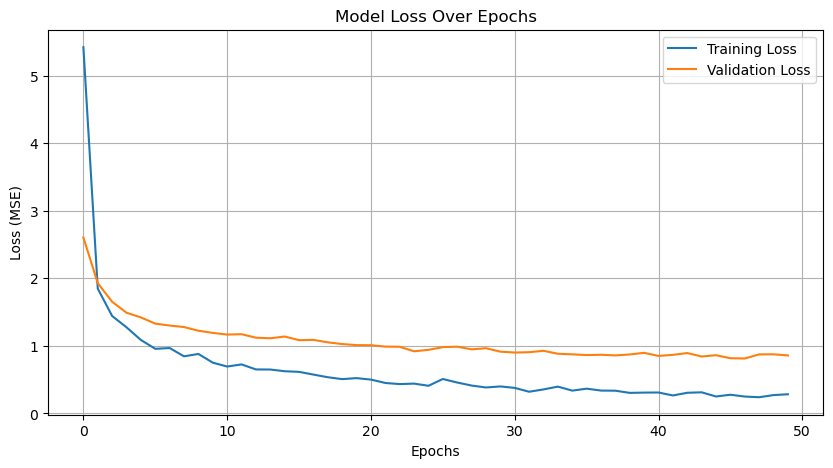

In [16]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

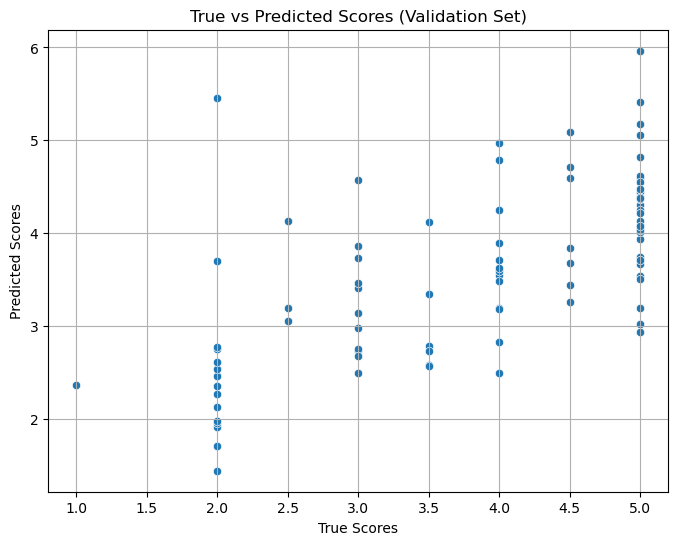

In [17]:
# Plot True vs Predicted Scores
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_val_pred.flatten())
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title('True vs Predicted Scores (Validation Set)')
plt.grid(True)
plt.show()

In [18]:
# Load test data
test_csv_path = r"C:\Users\Vibhore sagar\NLP\shl\shl-intern-hiring-assessment\Dataset\test.csv"
test_audio_dir = r"C:\Users\Vibhore sagar\NLP\shl\shl-intern-hiring-assessment\Dataset\audios\test"

test_df = pd.read_csv(test_csv_path)
test_df['filename'] = test_df['filename'].astype(str).str.strip()
test_df['filename'] = test_df['filename'].apply(lambda x: x if x.endswith('.wav') else x + '.wav')

In [19]:
# Extract features from test audio
X_test = []
for _, row in test_df.iterrows():
    file_path = os.path.join(test_audio_dir, row['filename'])
    try:
        features = extract_features(file_path)
        X_test.append(features)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

X_test = np.array(X_test)
X_test_scaled = scaler.transform(X_test)  # Apply same scaler from training

In [20]:
# Predict scores
test_preds = model.predict(X_test_scaled).flatten()

# Prepare submission DataFrame
submission_df = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_preds
})

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [21]:
# Round scores if needed (optional)
submission_df["label"] = submission_df["label"].clip(0, 5)  # Clip predictions to 0-5 range

In [22]:
# Save CSV file
submission_csv_path = r"C:\Users\Vibhore sagar\NLP\shl\shl-intern-hiring-assessment\submission.csv"
submission_df.to_csv(submission_csv_path, index=False)
print(f"Submission saved to: {submission_csv_path}")

Submission saved to: C:\Users\Vibhore sagar\NLP\shl\shl-intern-hiring-assessment\submission.csv
